In [ ]:
!pip install -q \
  torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 \
  --index-url https://download.pytorch.org/whl/cu124


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.9 MB/s eta 0:00:00


In [ ]:
!pip install -q \
  transformers==4.41.1 \
  peft==0.10.0 \
  accelerate==0.28.0 \
  bitsandbytes==0.41.3 \
  trl==0.8.5 \
  triton==2.1.0 \
  fsspec==2025.3.2 \
  pydantic==2.9.2 \
  fire==0.6.0 \
  huggingface-hub==0.28.1 \
  scikit-learn==1.6.1 \
  sklearn-compat==0.1.3 \
  fastai==2.7.19 \
  imbalanced-learn==0.13.0 \
  gradio==5.31.0 \
  diffusers==0.33.1

!pip uninstall numpy
!pip install numpy==1.26.4  # Stable and compatible with most existing modules


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which i

In [ ]:
from huggingface_hub import login

print("🔐 Login to Hugging Face. You must accept the license for google/gemma-2b.")
login()


🔐 Login to Hugging Face. You must accept the license for google/gemma-2b.


In [ ]:
import os
import torch
import json
import random
import numpy as np
import re
from tqdm import tqdm
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
from pydantic import BaseModel, Field
from typing import Literal

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [ ]:
def load_and_prepare_dataset(file_path):
    with open(file_path, "r") as f:
        raw_json = json.load(f)
    raw_examples = raw_json["data"]
    dataset = Dataset.from_list(raw_examples)
    return dataset

def extract_domain(text):
    match = re.search(r"Domain: (technical|medical|financial|general)", text)
    return match.group(1) if match else "unknown"

train_dataset = load_and_prepare_dataset("/content/multi_domain_main_dataset.json")
eval_dataset = load_and_prepare_dataset("/content/multi_domain_eval_dataset.json")

# Shuffle train
train_dataset = train_dataset.shuffle(seed=42)

# Preview domain counts
from collections import Counter
print("Train Distribution:", Counter([extract_domain(e["text"]) for e in train_dataset]))
print("Eval Distribution:", Counter([extract_domain(e["text"]) for e in eval_dataset]))


Train Distribution: Counter({'general': 3000, 'medical': 3000, 'technical': 3000, 'financial': 3000})
Eval Distribution: Counter({'medical': 25, 'financial': 25, 'general': 25, 'technical': 25})


In [ ]:
class OutputFormat(BaseModel):
    Domain: Literal["technical", "medical", "financial", "general"]


In [ ]:
model_id = "google/gemma-2b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def evaluate(model, tokenizer, dataset, max_samples=100):
    model.eval()
    y_true, y_pred = [], []

    for example in dataset.select(range(min(max_samples, len(dataset)))):
        # Remove label from input
        full_text = example["text"]
        user_query = full_text.split("Domain:")[0].strip()
        label = extract_domain(full_text)

        input_ids = tokenizer(user_query, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output_ids = model.generate(**input_ids, max_new_tokens=10)
        output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Extract predicted domain
        pred = "unknown"
        for domain in ["technical", "medical", "financial", "general"]:
            if f"Domain: {domain}" in output_text:
                pred = domain
                break

        y_true.append(label)
        y_pred.append(pred)

    print("🧪 Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🧩 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [ ]:
print("Evaluating Gemma before fine-tuning:")
evaluate(model, tokenizer, eval_dataset)


Evaluating Gemma before fine-tuning:
🧪 Classification Report:
              precision    recall  f1-score   support

   financial       0.00      0.00      0.00      25.0
     general       0.00      0.00      0.00      25.0
     medical       0.00      0.00      0.00      25.0
   technical       0.00      0.00      0.00      25.0
     unknown       0.00      0.00      0.00       0.0

    accuracy                           0.00     100.0
   macro avg       0.00      0.00      0.00     100.0
weighted avg       0.00      0.00      0.00     100.0

🧩 Confusion Matrix:
 [[ 0  0  0  0 25]
 [ 0  0  0  0 25]
 [ 0  0  0  0 25]
 [ 0  0  0  0 25]
 [ 0  0  0  0  0]]


In [ ]:
import numpy as np

training_args = TrainingArguments(
    output_dir="./gemma-router-ft",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=2e-5,
    fp16=True,
    report_to="none"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    dataset_text_field="text",
    args=training_args,
    max_seq_length=512
)

trainer.train()


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,2.595600,2.490206
2,2.485100,2.437041


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=Tru

TrainOutput(global_step=6000, training_loss=2.489397626241048, metrics={'train_runtime': 3231.4097, 'train_samples_per_second': 7.427, 'train_steps_per_second': 1.857, 'total_flos': 9031744852672512.0, 'train_loss': 2.489397626241048, 'epoch': 2.0})

In [ ]:
import os

# Recreate your output directories
OUTPUT_DIR = "./gemma_finetuned_classifier"
GGUF_OUTPUT_PATH = "./gemma-router.gguf"

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:
from peft import PeftModel

# Merge LoRA weights into base model before saving
base_model = model.merge_and_unload()
base_model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"✅ Fine-tuned model saved at: {OUTPUT_DIR}")


✅ Fine-tuned model saved at: ./gemma_finetuned_classifier


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define your saved model directory
OUTPUT_DIR = "./gemma_finetuned_classifier"

# Load tokenizer and fine-tuned model (LoRA is already merged)
tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR)
model = AutoModelForCausalLM.from_pretrained(OUTPUT_DIR, device_map="auto")

model.eval()
print("✅ Model reloaded successfully for evaluation.")


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


✅ Model reloaded successfully for evaluation.


In [ ]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b",
    torch_dtype=torch.float16,
    device_map="auto"
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
tokenizer.pad_token = tokenizer.eos_token

# Load LoRA adapter from the latest checkpoint
model = PeftModel.from_pretrained(base_model, "./gemma-router-ft/checkpoint-6000")

model.eval()
print("✅ Model loaded successfully from checkpoint-6000!")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded successfully from checkpoint-6000!


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import re

def extract_true_domain(text):
    match = re.search(r"Domain: (technical|medical|financial|general)", text)
    return match.group(1) if match else "unknown"

def evaluate_model(model, tokenizer, dataset, max_samples=100):
    y_true, y_pred = [], []

    for example in dataset.select(range(min(max_samples, len(dataset)))):
        full_text = example["text"]
        user_query = full_text.split("Domain:")[0].strip()
        label = extract_true_domain(full_text)

        inputs = tokenizer(user_query, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=10)
        output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Extract predicted domain
        prediction = "unknown"
        for domain in ["technical", "medical", "financial", "general"]:
            if f"Domain: {domain}" in output_text:
                prediction = domain
                break

        y_true.append(label)
        y_pred.append(prediction)

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("\n🔀 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Evaluate using your eval dataset
evaluate_model(model, tokenizer, eval_dataset)



📊 Classification Report:
              precision    recall  f1-score   support

   financial       1.00      0.64      0.78        25
     general       1.00      0.44      0.61        25
     medical       0.91      0.84      0.88        25
   technical       0.89      0.96      0.92        25
     unknown       0.00      0.00      0.00         0

    accuracy                           0.72       100
   macro avg       0.76      0.58      0.64       100
weighted avg       0.95      0.72      0.80       100


🔀 Confusion Matrix:
 [[16  0  0  1  8]
 [ 0 11  2  2 10]
 [ 0  0 21  0  4]
 [ 0  0  0 24  1]
 [ 0  0  0  0  0]]


In [ ]:
import os
import zipfile
from pathlib import Path

def download_model_folders():
    """Download gemma-router-ft and gemma_finetuned_classifier folders as zip."""

    folders_to_download = [
        "gemma-router-ft"
    ]

    output_zip = "gemma_models.zip"

    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder_name in folders_to_download:
            if os.path.exists(folder_name):
                print(f"Adding folder: {folder_name}")

                # Walk through the folder and add all files
                for root, dirs, files in os.walk(folder_name):
                    for file in files:
                        file_path = os.path.join(root, file)
                        # Add to zip maintaining folder structure
                        zipf.write(file_path, file_path)
                        print(f"  Added: {file_path}")

            else:
                print(f"⚠️  Folder not found: {folder_name}")

    if os.path.exists(output_zip):
        size_mb = os.path.getsize(output_zip) / (1024 * 1024)
        print(f"\n✅ Successfully created: {output_zip}")
        print(f"📦 Size: {size_mb:.2f} MB")
        print("You can now download this zip file to your local system.")
    else:
        print("❌ Failed to create zip file")

# Run the function
if __name__ == "__main__":
    download_model_folders()

Adding folder: gemma-router-ft
  Added: gemma-router-ft/checkpoint-3000/special_tokens_map.json
  Added: gemma-router-ft/checkpoint-3000/tokenizer_config.json
  Added: gemma-router-ft/checkpoint-3000/scheduler.pt
  Added: gemma-router-ft/checkpoint-3000/tokenizer.json
  Added: gemma-router-ft/checkpoint-3000/tokenizer.model
  Added: gemma-router-ft/checkpoint-3000/optimizer.pt
  Added: gemma-router-ft/checkpoint-3000/adapter_config.json
  Added: gemma-router-ft/checkpoint-3000/trainer_state.json
  Added: gemma-router-ft/checkpoint-3000/rng_state.pth
  Added: gemma-router-ft/checkpoint-3000/README.md
  Added: gemma-router-ft/checkpoint-3000/adapter_model.safetensors
  Added: gemma-router-ft/checkpoint-3000/training_args.bin
  Added: gemma-router-ft/checkpoint-6000/special_tokens_map.json
  Added: gemma-router-ft/checkpoint-6000/tokenizer_config.json
  Added: gemma-router-ft/checkpoint-6000/scheduler.pt
  Added: gemma-router-ft/checkpoint-6000/tokenizer.json
  Added: gemma-router-ft/chec

In [ ]:
!pip install -q nltk scikit-learn matplotlib seaborn torch
!pip install optuna --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.7 MB/s eta 0:00:00


In [ ]:
import os
import json
import torch
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
class DomainDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


In [ ]:
class MultiDomainLSTMClassifier:
    def __init__(self):
        self.tokenizer = None
        self.label_encoder = None
        self.vocab_size = 10000
        self.max_length = 100
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def extract_query(self, text):
        match = re.search(r'User query: (.*?)\nDomain:', text)
        return match.group(1) if match else ""

    def extract_domain(self, text):
        match = re.search(r'Domain: (.*)$', text)
        return match.group(1) if match else ""

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())
        tokens = text.split()
        tokens = [t for t in tokens if t not in self.stop_words and len(t) > 2]
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        return ' '.join(tokens)


In [ ]:
    def load_and_preprocess_data(self, train_path, eval_path):
        with open(train_path, 'r') as f:
            train_data = json.load(f)['data']
        with open(eval_path, 'r') as f:
            eval_data = json.load(f)['data']

        train_df = pd.DataFrame(train_data)
        eval_df = pd.DataFrame(eval_data)

        train_df['query'] = train_df['text'].apply(self.extract_query)
        train_df['domain'] = train_df['text'].apply(self.extract_domain)

        eval_df['query'] = eval_df['text'].apply(self.extract_query)
        eval_df['domain'] = eval_df['text'].apply(self.extract_domain)

        print(train_df['domain'].value_counts())
        return train_df, eval_df


In [ ]:
import json
import re
import torch
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import nltk

# Ensure NLTK assets are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

class MultiDomainLSTMClassifier:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.label_encoder = LabelEncoder()
        self.vocab_size = 10000
        self.max_length = 100
        self.tokenizer = None  # Will set later

    def extract_query(self, text):
        match = re.search(r'User query: (.*?)\nDomain:', text)
        return match.group(1) if match else ""

    def extract_domain(self, text):
        match = re.search(r'Domain: (.*)$', text)
        return match.group(1) if match else ""

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = text.split()
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens if t not in self.stop_words and len(t) > 2]
        return ' '.join(tokens)

    def load_and_preprocess_data(self, train_path, eval_path):
        print("Loading JSON data...")

        with open(train_path, 'r') as f:
            train_raw = json.load(f)['data']
        with open(eval_path, 'r') as f:
            eval_raw = json.load(f)['data']

        train_df = pd.DataFrame(train_raw)
        eval_df = pd.DataFrame(eval_raw)

        train_df['query'] = train_df['text'].apply(self.extract_query)
        train_df['domain'] = train_df['text'].apply(self.extract_domain)

        eval_df['query'] = eval_df['text'].apply(self.extract_query)
        eval_df['domain'] = eval_df['text'].apply(self.extract_domain)

        print(f"Train shape: {train_df.shape} | Eval shape: {eval_df.shape}")
        print(train_df['domain'].value_counts())

        return train_df, eval_df

    def prepare_data(self, train_df, eval_df):
        from sklearn.model_selection import train_test_split
        from tensorflow.keras.preprocessing.text import Tokenizer
        from tensorflow.keras.preprocessing.sequence import pad_sequences

        # Clean queries
        train_df['cleaned_query'] = train_df['query'].apply(self.clean_text)
        eval_df['cleaned_query'] = eval_df['query'].apply(self.clean_text)

        # Tokenizer
        all_texts = list(train_df['cleaned_query']) + list(eval_df['cleaned_query'])
        tokenizer = Tokenizer(num_words=self.vocab_size, oov_token="<OOV>")
        tokenizer.fit_on_texts(all_texts)

        self.tokenizer = tokenizer

        X_train = tokenizer.texts_to_sequences(train_df['cleaned_query'])
        X_eval = tokenizer.texts_to_sequences(eval_df['cleaned_query'])

        X_train = pad_sequences(X_train, maxlen=self.max_length, padding='post')
        X_eval = pad_sequences(X_eval, maxlen=self.max_length, padding='post')

        # Encode labels
        y_train = self.label_encoder.fit_transform(train_df['domain'])
        y_eval = self.label_encoder.transform(eval_df['domain'])

        return np.array(X_train), np.array(X_eval), np.array(y_train), np.array(y_eval), len(self.label_encoder.classes_)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
class LSTMDomainClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        hidden = self.dropout(torch.cat((output[:, -1, :self.lstm.hidden_size],
                                         output[:, 0, self.lstm.hidden_size:]), dim=1))
        return self.fc(hidden)


In [ ]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)


In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset), all_labels, all_preds


In [ ]:
# Initialize classifier
classifier = MultiDomainLSTMClassifier()
train_df, eval_df = classifier.load_and_preprocess_data(
    "/content/multi_domain_main_dataset.json",
    "/content/multi_domain_eval_dataset.json"
)

# Prepare
X_train, X_eval, y_train, y_eval, num_classes = classifier.prepare_data(train_df, eval_df)

# Train/val split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloaders
train_ds = DomainDataset(X_tr, y_tr)
val_ds = DomainDataset(X_val, y_val)
test_ds = DomainDataset(X_eval, y_eval)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

# Model setup
model = LSTMDomainClassifier(
    vocab_size=classifier.vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=num_classes,
    dropout=0.5
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_dl, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate_model(model, val_dl, criterion, device)
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")


Loading JSON data...
Train shape: (12000, 3) | Eval shape: (100, 3)
domain
general      3000
medical      3000
technical    3000
financial    3000
Name: count, dtype: int64
Epoch 1: Train Loss 0.7012, Acc 0.7226 | Val Loss 0.3547, Acc 0.8658
Epoch 2: Train Loss 0.2532, Acc 0.9109 | Val Loss 0.2107, Acc 0.9217
Epoch 3: Train Loss 0.1358, Acc 0.9558 | Val Loss 0.1687, Acc 0.9392
Epoch 4: Train Loss 0.0718, Acc 0.9765 | Val Loss 0.1556, Acc 0.9433
Epoch 5: Train Loss 0.0442, Acc 0.9859 | Val Loss 0.1532, Acc 0.9463
Epoch 6: Train Loss 0.0274, Acc 0.9918 | Val Loss 0.1671, Acc 0.9458
Epoch 7: Train Loss 0.0171, Acc 0.9958 | Val Loss 0.1662, Acc 0.9458
Epoch 8: Train Loss 0.0105, Acc 0.9979 | Val Loss 0.1740, Acc 0.9487
Epoch 9: Train Loss 0.0082, Acc 0.9978 | Val Loss 0.1766, Acc 0.9508
Epoch 10: Train Loss 0.0056, Acc 0.9986 | Val Loss 0.1898, Acc 0.9521



Test Accuracy: 0.9800

Classification Report:
              precision    recall  f1-score   support

   financial       1.00      0.96      0.98        25
     general       0.96      0.96      0.96        25
     medical       1.00      1.00      1.00        25
   technical       0.96      1.00      0.98        25

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



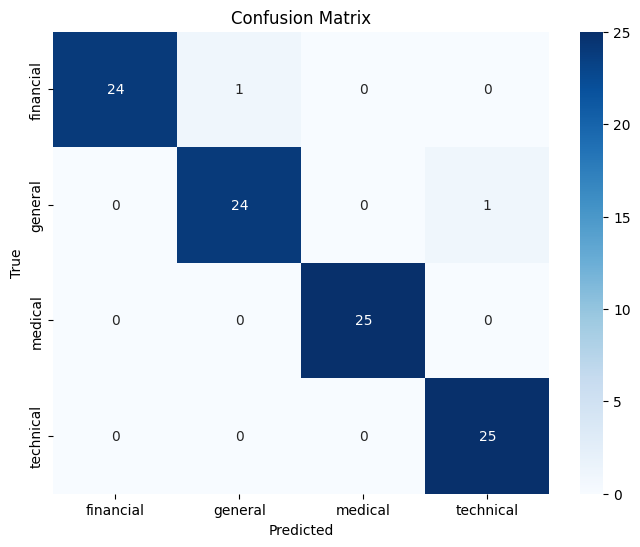

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Final Evaluation
test_loss, test_acc, y_true, y_pred = evaluate_model(model, test_dl, criterion, device)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classifier.label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.label_encoder.classes_, yticklabels=classifier.label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def predict_random_samples(model, dataset, df, classifier, num_samples=4):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        x, true_label = dataset[idx]
        x_tensor = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x_tensor).argmax(dim=1).item()

        print(f"\n🧠 Query: {df.iloc[idx]['query']}")
        print(f"✅ True Domain: {classifier.label_encoder.classes_[true_label]}")
        print(f"🔮 Predicted Domain: {classifier.label_encoder.classes_[pred]}")

predict_random_samples(model, test_ds, eval_df, classifier)



🧠 Query: When is Cash Value Life Insurance a good or bad idea?
✅ True Domain: financial
🔮 Predicted Domain: financial

🧠 Query: Does viral challenge reveal further evidence of skin-deep resilience in African Americans from disadvantaged backgrounds?
✅ True Domain: medical
🔮 Predicted Domain: medical

🧠 Query: What artist did Beyonce duet with in the single, "Deja Vu''?
✅ True Domain: general
🔮 Predicted Domain: general

🧠 Query: Is hospital readmission associated with poor survival after esophagectomy for esophageal cancer?
✅ True Domain: medical
🔮 Predicted Domain: medical
